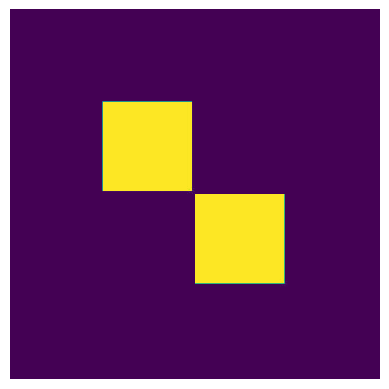

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
import numpy as np
import pydicom
import datetime
from pydicom.dataset import Dataset, FileDataset, FileMetaDataset
from PIL import Image

examples_dir='example-data/png/'
filename='Kwadraty2.jpg'
image = mpimg.imread(examples_dir + filename)
if len(image.shape) == 3:
    image = np.mean(image, axis=2)  # ?????? bez tego nie działa radon ale to koloruje obrazek
filename = 'Kwadraty2'
plt.imshow(image)
plt.axis('off')
plt.show()

In [42]:
def bresenham_algorithm(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))  
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

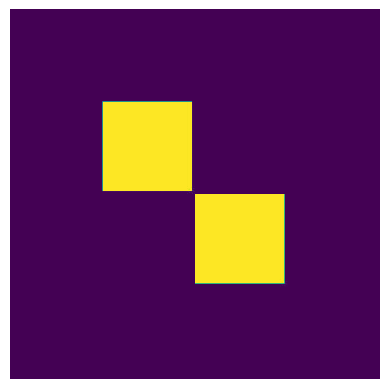

In [43]:
def load_image(filepath):
    if filepath.lower().endswith('.dcm'):
        dicom_data = pydicom.dcmread(filepath)
        image = dicom_data.pixel_array.astype(np.float32)
    else:
        image = Image.open(filepath).convert('L')
        image = np.array(image, dtype=np.float32)
    return image

image=load_image(f'example-data/dicom/{filename}.dcm')
if len(image.shape) == 3:
    image = np.mean(image, axis=2)  

plt.imshow(image)
plt.axis('off')
plt.show()

In [44]:
def compute_geometry(image_shape):
    x_center = image_shape[0] / 2
    y_center = image_shape[1] / 2
    radius = np.sqrt(x_center**2 + y_center**2)
    return x_center, y_center, radius

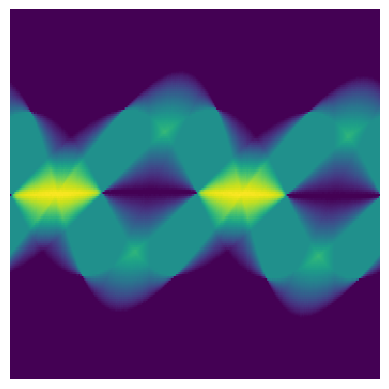

In [45]:
def radon_transform(image, step, detectors_num, span, filename):
    step = np.radians(step)  
    span = np.radians(span)
    x_center, y_center, radius = compute_geometry(image.shape)
    sinogram = np.zeros((int(2 * np.pi / step), detectors_num))
    
    for i in range(sinogram.shape[0]):
        angle = i * step
        emitter_pos = [int(x_center + radius * np.cos(angle)), int(y_center + radius * np.sin(angle))]
        
        detector_first_pos = angle + np.pi - span / 2
        detector_last_pos = angle + np.pi + span / 2
        det_angles = np.linspace(detector_first_pos, detector_last_pos, detectors_num)
        
        for det_idx, det_angle in enumerate(det_angles):
            det_pos = [int(x_center + radius * np.cos(det_angle)), int(y_center + radius * np.sin(det_angle))]
            points = list(bresenham_algorithm(emitter_pos[0], emitter_pos[1], det_pos[0], det_pos[1]))
            
            bright_points = sum(1 for p in points if 0 <= p[0] < image.shape[0] and 0 <= p[1] < image.shape[1])
            sum_bright = sum(image[p[0], p[1]] for p in points if 0 <= p[0] < image.shape[0] and 0 <= p[1] < image.shape[1])
            
            sinogram[i, det_idx] = sum_bright / bright_points if bright_points > 0 else 0

    sinogram_scaled = (255.0 / np.amax(sinogram)) * sinogram
    sinogram_scaled = sinogram_scaled.astype(np.uint8)
    sinogram_image = Image.fromarray(sinogram_scaled.T, mode='L')
    sinogram_resized = sinogram_image.resize((image.shape[1], image.shape[0]), resample=Image.NEAREST)
    sinogram_resized.save(f'results/sinograms/{filename}.png')
    plt.imshow(sinogram_resized)
    plt.axis('off')
    plt.show()

    return sinogram

sinogram = radon_transform(image, 1, 180, 180, filename)

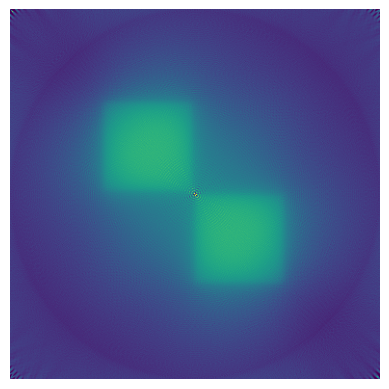

In [46]:
def inverse_radon_transform(sinogram, image_shape, step, span, filename):
    x_center, y_center, radius = compute_geometry(image_shape)
    step = np.radians(step)
    span = np.radians(span)
    
    result = np.zeros(image_shape)
    norm_matrix = np.zeros(image_shape)
    
    for i in range(sinogram.shape[0]):
        angle = i * step
        emitter_pos = [int(x_center + radius * np.cos(angle)), int(y_center + radius * np.sin(angle))]
        
        for j in range(sinogram.shape[1]):
            det_angle = angle + np.pi - span / 2 + j * span / sinogram.shape[1]
            det_pos = [int(x_center + radius * np.cos(det_angle)), int(y_center + radius * np.sin(det_angle))]
            
            points = list(bresenham_algorithm(emitter_pos[0], emitter_pos[1], det_pos[0], det_pos[1]))
            
            for point in points:
                if 0 <= point[0] < image_shape[0] and 0 <= point[1] < image_shape[1]:
                    result[point[0], point[1]] += sinogram[i, j]
                    norm_matrix[point[0], point[1]] += 1
    
    result = np.divide(result, norm_matrix, out=np.zeros_like(result), where=norm_matrix!=0)
    
    result_scaled = (255.0 / np.amax(result)) * result
    result_image = Image.fromarray(result_scaled.astype(np.uint8), mode='L')
    result_image.save(f'results/recovered_images/png/{filename}.png')

    plt.imshow(result_image)
    plt.axis('off')
    plt.show()

    return result

result = inverse_radon_transform(sinogram, image.shape, 1, 180, filename)


In [47]:

def save_dicom(image_array, filename, patient_name, patient_id, date, comment):
    ds = Dataset()
    ds.PatientName = patient_name
    ds.PatientID = patient_id
    ds.StudyDate = date
    ds.ImageComments = comment

    ds.Rows, ds.Columns = image_array.shape
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.SamplesPerPixel = 1
    ds.BitsAllocated = 8
    ds.BitsStored = 8
    ds.HighBit = 7
    ds.PixelRepresentation = 0

    ds.Modality = "OT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = pydicom.uid.generate_uid()

    ds.file_meta = FileMetaDataset()
    ds.file_meta.MediaStorageSOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
    ds.file_meta.MediaStorageSOPInstanceUID = ds.SOPInstanceUID
    ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    ds.PixelData = image_array.tobytes()

    ds.save_as(filename, write_like_original=False)

image_array = np.array(result, dtype=np.uint8)

save_dicom(
    image_array,
    f'results/recovered_images/dicom/{filename}.dcm',
    patient_name='Jan Kowalski',
    patient_id='123456',
    date='20250314',
    comment='Komentarz'
)
